# Stroke Prediction

## Abstract

This notebook is an analysis of a [stroke indicators dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).  The analysis prepares the dataset for input to logistic regression and random forest classifiers, which are trained on the indicators to predict the likelihood of a stroke.  The dataset is highly imbalanced, with a 5% stroke positive rate.  The best predictive performance was achieved with a random forest classifier, where class imbalance was accounted for by random undersampling of the stroke negative rate in each bootstrap sample.  After hyperparameter optimization, this model achieved an 85% sensitivity (true stroke positive rate) and a 70% specificity (true stroke negative rate) evalulated via cross validation.

## Data Exploration and Preparation

### Data Set Attributes

The data set attributes and their descriptions are as follows: 

1. id: unique patient identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

### Class Imbalance and Category Populations

Look at the data for target class imbalance (stroke positive vs. negative rate) and indicator classes with small rates (few percent or less) to exclude from the machine learning models.

Import libraries and read-in the dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv( "./data/healthcare-dataset-stroke-data.csv" )
print( data.info() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


Drop unique patient id as it will not be used by the machine learning models in predicting stroke

In [2]:
data.drop( columns=['id'], inplace=True )

For ease of display, rename attributes and classes, and convert all names to lower-case.

In [3]:
renamed_columns = {
    'ever_married':'married',
    'work_type':'occupation',
    'Residence_type':'residence',
    'smoking_status':'smoking'
}
data.rename(columns = renamed_columns, inplace = True)
#print( data.info() )

data['gender'] = data['gender'].str.lower()

data['occupation'].replace( to_replace={'Govt_job':'government'}, inplace=True )
data['occupation'] = data['occupation'].str.lower()

data['residence'] = data['residence'].str.lower()

rename_smoking = {
    'never smoked':'never',
    'Unknown':'unknown',
    'formerly smoked':'former',
    'smokes':'current'
}
data['smoking'].replace( to_replace=rename_smoking, inplace=True )

Plot each attribute to look for non-sensical values and classes with small populations. 

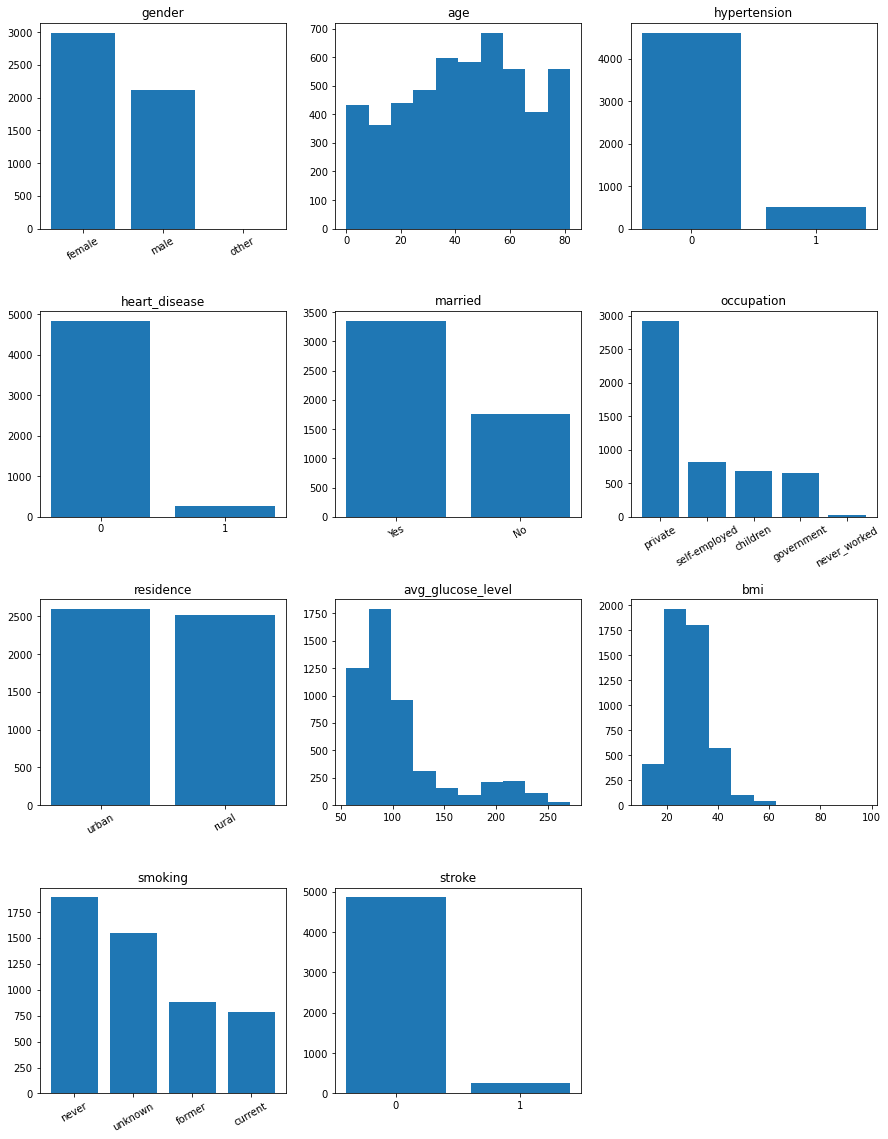

In [4]:
plt.figure(figsize=(15, 25))
plot_num = 1

for col in data.columns :
    plt.subplot(5,3,plot_num)
    if col in [ 'age', 'avg_glucose_level', 'bmi' ] :
        plt.hist( data[col] )
    else :
        col_counts = data[col].value_counts()
        plt.bar( col_counts.index.astype('str'), col_counts.values )
        if pd.api.types.is_string_dtype( data[col] ) :
            plt.xticks(rotation=30)
    plt.title(col)
    plot_num += 1

plt.subplots_adjust( hspace=0.4 )
plt.show()

The data set is highly imbalanced, where 5% of patients (249 of 5110 total) are stroke positive.  This imbalance will need to be taken into account in training the machine learning models.

In [5]:
print( 'Stroke counts:' )
print( data['stroke'].value_counts() )

Stroke counts:
0    4861
1     249
Name: stroke, dtype: int64


The gender other and occupation never_worked classes are only 1 and 22 of 5110 total patients, respectively.  These clases will be excluded from the machine learning models due to their size.

In [6]:
print( 'gender counts:' )
print( data['gender'].value_counts() )

print( '\n' )
print( 'occupation counts:' )
print( data['occupation'].value_counts() )

gender counts:
female    2994
male      2115
other        1
Name: gender, dtype: int64


occupation counts:
private          2925
self-employed     819
children          687
government        657
never_worked       22
Name: occupation, dtype: int64


### Missing Data

Missing data in the smoking status category is denoted by the "unknown" class.  Nearly 30% of patients have unknown smoking status, so imputing these data from the other smoking status classes might skew the data set.  Other stroke indicators in the data set include hypertension and heart disease, for which smoking is a risk factor.  Hypertension and heart disease might therefore serve as proxies for missing smoking status.  For these reasons, unknown smoking status will be left as-is.

The other missing data are BMI:

In [7]:
print( "Missing value counts:")
print( data.isna().sum() )

Missing value counts:
gender                 0
age                    0
hypertension           0
heart_disease          0
married                0
occupation             0
residence              0
avg_glucose_level      0
bmi                  201
smoking                0
stroke                 0
dtype: int64


Four percent of patients have missing BMI.  To determine whether these patients can be excluded, look at the number of patients with missing BMI who are stroke positive.

In [8]:
print( 'Number of patients with missing BMI data who are stroke positive:')
print( data[ ( data['bmi'].isna() ) & ( data['stroke'] == 1 ) ].shape[0] )

Number of patients with missing BMI data who are stroke positive:
40


Roughly 1/6 of all stroke positive patients have missing BMI data.  Therefore, patients with missing BMI will not be excluded.  Instead, impute the missing BMI values.

The CDC has different BMI categories (e.g. healthy, overweight) for [children](https://www.cdc.gov/healthyweight/assessing/bmi/childrens_bmi/about_childrens_bmi.html) and [adults](https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html), so look at their BMI separately.

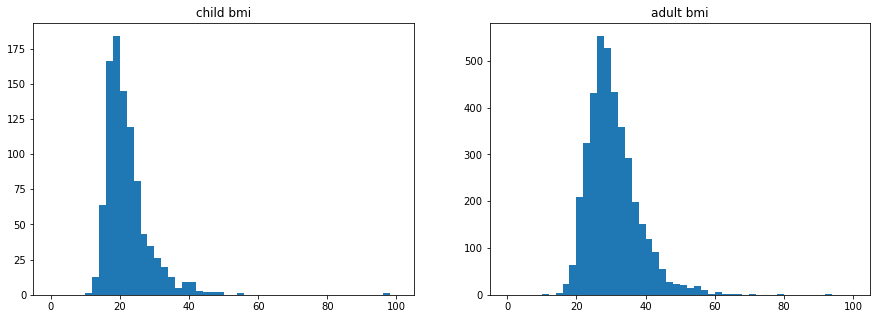

Child BMI mean = 22.0
Adult BMI mean = 30.5


In [9]:
mask_child = data['age'] < 20
mask_adult = data['age'] >= 20

bmi_child = data.loc[mask_child,'bmi'].copy()
bmi_adult = data.loc[mask_adult,'bmi'].copy()

mean_bmi_child = bmi_child.mean()
mean_bmi_adult = bmi_adult.mean()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist( bmi_child, range=(0,100), bins=50 )
plt.title('child bmi')
plt.subplot(1,2,2)
plt.hist( bmi_adult, range=(0,100), bins=50)
plt.title('adult bmi')
plt.show()

print( 'Child BMI mean = %.1f' % mean_bmi_child )
print( 'Adult BMI mean = %.1f' % mean_bmi_adult )

The lower overall BMI for children than adults suggests imputing missing BMI for children and adults separately.

Also look at BMI between stroke positive and negative patients.

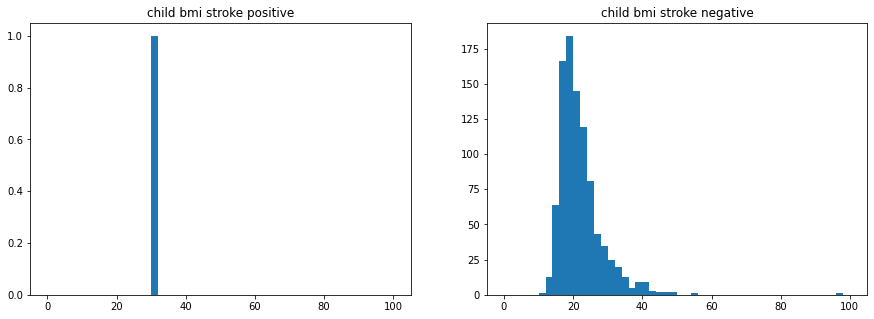

Child stroke positive BMI mean = 30.9
Child stroke negative BMI mean = 22.0
966 total child patients


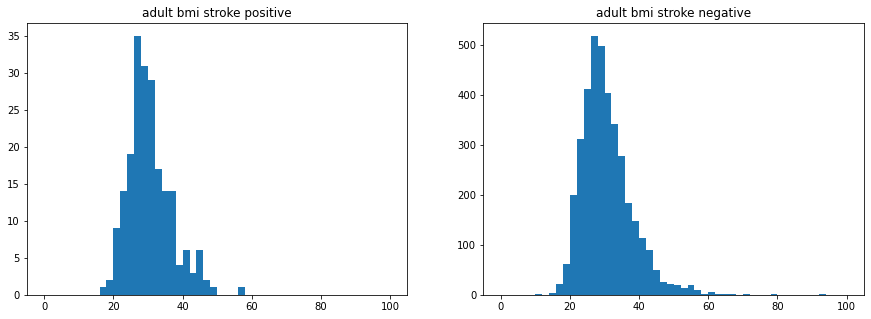

Adult stroke positive BMI mean = 30.47
Adult stroke negative BMI mean = 30.55


In [10]:
mask_stroke_pos = data['stroke'] == 1
mask_stroke_neg = data['stroke'] == 0

bmi_child_stroke_pos = data.loc[(mask_child)&(mask_stroke_pos),'bmi'].copy()
bmi_child_stroke_neg = data.loc[(mask_child)&(mask_stroke_neg),'bmi'].copy()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist( bmi_child_stroke_pos, range=(0,100), bins=50 )
plt.title('child bmi stroke positive')
plt.subplot(1,2,2)
plt.hist( bmi_child_stroke_neg, range=(0,100), bins=50 )
plt.title('child bmi stroke negative')
plt.show()

print( 'Child stroke positive BMI mean = %.1f' % bmi_child_stroke_pos.mean() )
print( 'Child stroke negative BMI mean = %.1f' % bmi_child_stroke_neg.mean() )
print( mask_child.sum(), 'total child patients' )

bmi_adult_stroke_pos = data.loc[(mask_adult)&(mask_stroke_pos),'bmi'].copy()
bmi_adult_stroke_neg = data.loc[(mask_adult)&(mask_stroke_neg),'bmi'].copy()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist( bmi_adult_stroke_pos, range=(0,100), bins=50 )
plt.title('adult bmi stroke positive')
plt.subplot(1,2,2)
plt.hist( bmi_adult_stroke_neg, range=(0,100), bins=50 )
plt.title('adult bmi stroke negative')
plt.show()

print( 'Adult stroke positive BMI mean = %.2f' % bmi_adult_stroke_pos.mean() )
print( 'Adult stroke negative BMI mean = %.2f' % bmi_adult_stroke_neg.mean() )

Only 1 of roughly 1000 child patients are stroke positive, and the adult BMI mean are nearly identical between stroke positive and negative.  Therefore, impute missing BMI from the means of all children and adults separately (n.b. could also set missing BMI to the modes).

In [11]:
mask_missing_bmi = data['bmi'].isna()

data.loc[(mask_missing_bmi)&(mask_child),'bmi'] = mean_bmi_child
data.loc[(mask_missing_bmi)&(mask_adult),'bmi'] = mean_bmi_adult

print( "Check missing value counts:")
print( data.isna().sum() )

Check missing value counts:
gender               0
age                  0
hypertension         0
heart_disease        0
married              0
occupation           0
residence            0
avg_glucose_level    0
bmi                  0
smoking              0
stroke               0
dtype: int64


### Prepare Data for Machine Learning

Convert categorical data to binary data so it can be used in machine learning.  This also enables calculation of correlations.

In [12]:
data['married'].replace( to_replace={'No':0,'Yes':1}, inplace=True )

cols_to_convert = ['gender','occupation','residence','smoking']

binary_data = pd.get_dummies( data[cols_to_convert] )
data = pd.concat( [binary_data, data], axis=1 )
data.drop( columns=cols_to_convert, inplace=True )

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender_female             5110 non-null   uint8  
 1   gender_male               5110 non-null   uint8  
 2   gender_other              5110 non-null   uint8  
 3   occupation_children       5110 non-null   uint8  
 4   occupation_government     5110 non-null   uint8  
 5   occupation_never_worked   5110 non-null   uint8  
 6   occupation_private        5110 non-null   uint8  
 7   occupation_self-employed  5110 non-null   uint8  
 8   residence_rural           5110 non-null   uint8  
 9   residence_urban           5110 non-null   uint8  
 10  smoking_current           5110 non-null   uint8  
 11  smoking_former            5110 non-null   uint8  
 12  smoking_never             5110 non-null   uint8  
 13  smoking_unknown           5110 non-null   uint8  
 14  age     

Apply min-max scaling to the continuous data (age, avg_glucose_level, and bmi) so they have the same range as the binary data.

In [13]:
from sklearn.preprocessing import minmax_scale

cols_to_scale = ['age','avg_glucose_level','bmi']
for col in cols_to_scale :
    data[col] = minmax_scale(data[col])

data[cols_to_scale].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000
mean,0.526692,0.235563,0.213301
std,0.276033,0.209046,0.088402
min,0.000000,0.000000,0.000000
25%,0.304199,0.102137,0.152635
50%,0.548340,0.169721,0.206186
75%,0.743652,0.272228,0.257732
max,1.000000,1.000000,1.000000


### Correlations

Calculate correlations between the stroke indicators and the instaces of stroke:

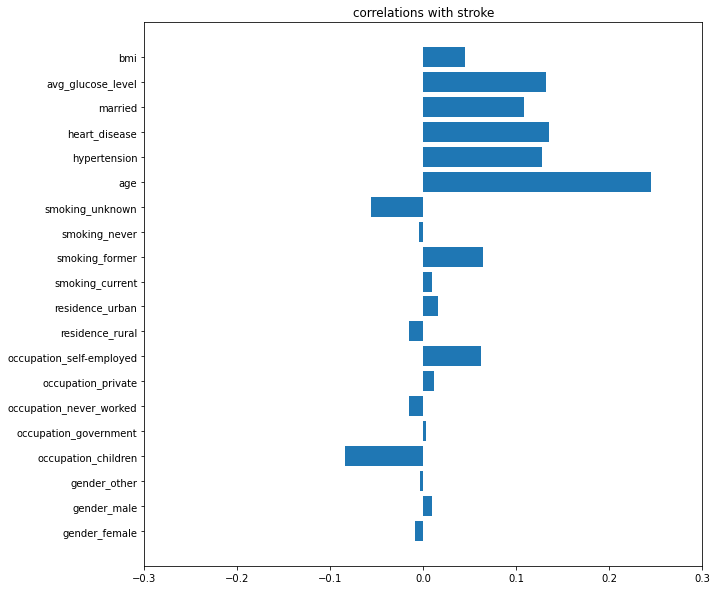

In [14]:
corrs_stroke = data.corr()['stroke']
corrs_stroke.drop( labels=['stroke'], inplace=True )

plt.figure(figsize=(10,10))
plt.barh( corrs_stroke.index, corrs_stroke.values )
plt.xlim(-0.3, 0.3)
plt.title('correlations with stroke')
plt.show()

Indicators with the largest correlation with stroke include heart disease, hypertension, and glucose level (related to diabetes), which aligns with the ranking of stroke risk factors given [here](https://www.hopkinsmedicine.org/health/conditions-and-diseases/stroke/risk-factors-for-stroke).  While smoking is also a strong risk factor, the correlation between smoking and stroke above might be reduced due to missing smoking status data.

Remove redundant data for machine learning.  Remove one of the two residence columns, and keep one of the three gender columns since gender_other contains only one patient.  Keep residence_urban and gender_male since they have the strongest correlations amongst their respective category.

In [15]:
data.drop( columns=['residence_rural','gender_female','gender_other'], inplace=True )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender_male               5110 non-null   uint8  
 1   occupation_children       5110 non-null   uint8  
 2   occupation_government     5110 non-null   uint8  
 3   occupation_never_worked   5110 non-null   uint8  
 4   occupation_private        5110 non-null   uint8  
 5   occupation_self-employed  5110 non-null   uint8  
 6   residence_urban           5110 non-null   uint8  
 7   smoking_current           5110 non-null   uint8  
 8   smoking_former            5110 non-null   uint8  
 9   smoking_never             5110 non-null   uint8  
 10  smoking_unknown           5110 non-null   uint8  
 11  age                       5110 non-null   float64
 12  hypertension              5110 non-null   int64  
 13  heart_disease             5110 non-null   int64  
 14  married 

# Predicting Stroke With Machine Learning

Train logistic regression and random forrest classifiers on the data set to predict the likelihood of stroke.  Accounting for data set imbalance will be important in training the models.

## Features and Target

Instantiate features (stroke indicators) and target classes (stroke positive or negative) for the machine learning models:

In [16]:
from sklearn.utils import shuffle

data = shuffle( data, random_state=1 )

target = 'stroke'
features = data.columns
features = features.drop(target)
X = data[features]
Y = data[target]

## Model evaluation

The goal is to predict the likelihood of stroke.  Since the dataset is highly imbalanced, the performance metrics used are sensitivity (true positive rate) and specificity (true negative rate), where importance will be placed on sensitivity.  Overall accuracy will also be reported.

Performance metrics are evaluated using cross validation with stratification, where the proportions of target classes are equal across folds.  Five folds are used so that each fold contains approximately 1000 patients.

Below are helper functions for generating and displaying scores (i.e. performance metrics) from cross validation for a given machine learning model.  The mean and standard deviation of scores across the fold combinations are reported.  Train and test scores are reported to evaluate overtraining. 

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

strat_kfold = StratifiedKFold( n_splits=5 )

score_list = ['recall','balanced_accuracy','accuracy']

def get_cross_val_scores( model, X, Y ) :

    return cross_validate( model, X, Y, cv=strat_kfold, scoring=score_list, return_train_score=True )

def get_mean_stdev( scores ) :

    return ( np.mean( scores ), np.std( scores ) )

def print_scores( cv_dict, test_scores = True ) :
    
    for sample in ( 'test', 'train' ) :

        if sample == 'train' and not test_scores : continue
        
        print( '\n%s Scores:' % sample.capitalize() )
        sensitivity = cv_dict[ sample + '_recall']
        balanced_accuracy = cv_dict[ sample + '_balanced_accuracy' ]
        accuracy = cv_dict[ sample + '_accuracy' ]
        specificity = 2 * balanced_accuracy - sensitivity

        print( 'Sensitivity mean = %.3f, stdev = %.3f' % get_mean_stdev( sensitivity ) )
        print( 'Specificity mean = %.3f, stdev = %.3f' % get_mean_stdev( specificity ) )
        #print( 'Balanced accuracy mean = %.3f, stdev = %.3f' % get_mean_stdev( balanced_accuracy ) )
        print( 'Overall accuracy mean = %.3f, stdev = %.3f' % get_mean_stdev( accuracy ) )

## Logistic Regression

### Unbalanced Data

First train a logistic regression model without accounting for data set imbalance:

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression( random_state=1 )
scores_lr = get_cross_val_scores( lr, X, Y )

print( '\nScores for logistic regression without class balancing:')
print_scores( scores_lr )


Scores for logistic regression without class balancing:

Test Scores:
Sensitivity mean = 0.004, stdev = 0.008
Specificity mean = 1.000, stdev = 0.000
Overall accuracy mean = 0.951, stdev = 0.000

Train Scores:
Sensitivity mean = 0.002, stdev = 0.002
Specificity mean = 1.000, stdev = 0.000
Overall accuracy mean = 0.951, stdev = 0.000


The model gives excellent specificity (100%) but poor (sub-percent) sensitivity.  This is due to the large imbalance in the data set and the model optimizing for overall accuracy.

### Class Balancing

Train logistic regression with class balancing, which balances the training data by class weighting (see [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

In [19]:
lr_balanced = LogisticRegression( class_weight='balanced', random_state=1 )
scores_lr_balanced = get_cross_val_scores( lr_balanced, X, Y )

print( '\nScores for logistic regression with class balancing:')
print_scores( scores_lr_balanced )


Scores for logistic regression with class balancing:

Test Scores:
Sensitivity mean = 0.795, stdev = 0.046
Specificity mean = 0.736, stdev = 0.018
Overall accuracy mean = 0.739, stdev = 0.017

Train Scores:
Sensitivity mean = 0.820, stdev = 0.013
Specificity mean = 0.737, stdev = 0.009
Overall accuracy mean = 0.741, stdev = 0.008


Logistic regression with class balancing gives a much better senstivity (near 80%), but at the cost of a lower specificity (near 74%).  This tradeoff is acceptible since importance is placed on sensitivity.

Overfitting is not an is not an issue here, as sensitivity is only about 3% lower in the test samples than in the training samples and specificity is nearly identical in the test and training samples.  Relatively low variation of the sensitivity and specificity in the test sample across folds (5% and 2% standard deviation, respectively) also suggests the model should generalize well to new data.

### Over-Weighting

Sensitivity can be further improved by futher class weighting.  Since stroke positive patients are 5% of all patients, class balancing weights positive cases by a factor of 20.  The effect of over-weighting positive cases by a factor of 40 is shown below.

In [20]:
weights = { 0: 1, 1: 40}
lr_weighted = LogisticRegression( class_weight=weights, random_state=1 )
scores_lr_weighted = get_cross_val_scores( lr_weighted, X, Y )

print( '\nScores for logistic regression with class over-weighting:')
print_scores( scores_lr_weighted )


Scores for logistic regression with class over-weighting:

Test Scores:
Sensitivity mean = 0.908, stdev = 0.051
Specificity mean = 0.608, stdev = 0.019
Overall accuracy mean = 0.623, stdev = 0.018

Train Scores:
Sensitivity mean = 0.914, stdev = 0.008
Specificity mean = 0.610, stdev = 0.012
Overall accuracy mean = 0.625, stdev = 0.012


Doubling the weight applied to positive cases improves sensitivity to 91%, but specificity drops to 61%.  Specificity near 50% is undesireable, so balanced class weighting is the optimal choice.

### Feature List Optimization

Logistic regression can be improved by choosing an optimal subset of features.  This is done here using recursive feature elimination.

In [21]:
from sklearn.feature_selection import RFECV

feature_selector = RFECV( lr_balanced, cv=strat_kfold )
feature_selector.fit( X, Y )

optimized_columns = X.columns[ feature_selector.support_ ]
print( '\nOptimized feature list:')
for col in optimized_columns :
    print( col )

X_optimized = X[optimized_columns]
scores_lr_balanced_optimized = get_cross_val_scores( lr_balanced, X_optimized, Y )

print( '\nScores for logistic regression with class balancing and optimized feature list:')
print_scores( scores_lr_balanced_optimized )


Optimized feature list:
occupation_children
age
hypertension
heart_disease
avg_glucose_level
bmi

Scores for logistic regression with class balancing and optimized feature list:

Test Scores:
Sensitivity mean = 0.791, stdev = 0.064
Specificity mean = 0.738, stdev = 0.021
Overall accuracy mean = 0.741, stdev = 0.020

Train Scores:
Sensitivity mean = 0.800, stdev = 0.010
Specificity mean = 0.737, stdev = 0.007
Overall accuracy mean = 0.740, stdev = 0.007


An optimized subset of features had little effect on the performance of logistic regression with class balancing.

### Logistic Regression Results Summary

The best performance for logistic regression was acheieved with class balancing and the full feature set, where the sensitivity and specificity are 80% and 74%, respectively.

## Random Forest Classifier

### Unbalanced Data

First train a random forest classifier without accounting for data set imbalance:

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier( random_state=1 )
scores_rf = get_cross_val_scores( rf, X, Y )

print( '\nScores for a random forest without class balancing:')
print_scores( scores_rf )


Scores for a random forest without class balancing:

Test Scores:
Sensitivity mean = 0.008, stdev = 0.010
Specificity mean = 0.998, stdev = 0.001
Overall accuracy mean = 0.950, stdev = 0.002

Train Scores:
Sensitivity mean = 1.000, stdev = 0.000
Specificity mean = 1.000, stdev = 0.000
Overall accuracy mean = 1.000, stdev = 0.000


The model gives excellent specificity (100%) but poor (sub-percent) sensitivity.  This again is due to the large imbalance in the data set and the model optimizing for overall accuracy.

### Class Balancing

Retrain the model with class balancing in each bootstrap sample, which is a random subsample of the data used to train a single decision tree in the random forest.  The class balancing is done by class weighting (see [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

In [23]:
rf_balanced = RandomForestClassifier( random_state=1, class_weight='balanced_subsample' )
scores_rf_balanced = get_cross_val_scores( rf_balanced, X, Y )

print( '\nScores for a random forest with class balancing via weighting:')
print_scores( scores_rf_balanced )


Scores for a random forest with class balancing via weighting:

Test Scores:
Sensitivity mean = 0.004, stdev = 0.008
Specificity mean = 0.998, stdev = 0.001
Overall accuracy mean = 0.950, stdev = 0.001

Train Scores:
Sensitivity mean = 0.999, stdev = 0.002
Specificity mean = 1.000, stdev = 0.000
Overall accuracy mean = 1.000, stdev = 0.000


Class balancing in each boostrap sample has little effect on the performance.  This could be due to the bootstrap samples containing few or no instances of the minority class.  For a good discussion of this problem see [this article](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/).

### Majority Undersampling

A solution to the problem above is class balancing in each boostrap sample by undersampling the majority class.  This is referred to as a balanced random forest and is implemented in [BalancedRandomForestClassifier](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html).

In [24]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier( random_state=1 )
scores_brf = get_cross_val_scores( brf, X, Y )

print( '\nScores for a balanced random forest:')
print_scores( scores_brf )


Scores for a balanced random forest:

Test Scores:
Sensitivity mean = 0.835, stdev = 0.029
Specificity mean = 0.705, stdev = 0.014
Overall accuracy mean = 0.711, stdev = 0.014

Train Scores:
Sensitivity mean = 1.000, stdev = 0.000
Specificity mean = 0.722, stdev = 0.013
Overall accuracy mean = 0.735, stdev = 0.012


The balanced random forest gives much improved results, with 84% sensitivity and 71% specificity.  These results are similar to those of logistic regression with class balancing.

### Hyperparamter Optimization

The balanced random forest overfits the data as indicated by the 16% difference in sensitivity between the training and test samples.  The overfitting can be corrected by optimizing a set of hyperparamter values that restrict the extent of the decision trees.  This is done via grid search.

In [25]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "max_depth": [5,10,15,20],
    "min_samples_leaf": [5,7,9],
}

grid_search = GridSearchCV( brf, param_grid=hyperparameters, cv=strat_kfold )
grid_search.fit(X, Y)

print( '\nOptimized hyperparameters')
print(grid_search.best_params_)

scores_brf_optimized = get_cross_val_scores( grid_search.best_estimator_, X, Y )

print( '\nScores for a balanced random forest with hyperparameter optimization:')
print_scores( scores_brf_optimized )


Optimized hyperparameters
{'max_depth': 10, 'min_samples_leaf': 5}

Scores for a balanced random forest with hyperparameter optimization:

Test Scores:
Sensitivity mean = 0.847, stdev = 0.047
Specificity mean = 0.698, stdev = 0.011
Overall accuracy mean = 0.706, stdev = 0.011

Train Scores:
Sensitivity mean = 0.909, stdev = 0.010
Specificity mean = 0.705, stdev = 0.012
Overall accuracy mean = 0.715, stdev = 0.012


Hyperparameter optimization reduced overfitting by the balanced random forest, where the difference in sensitivity between the test and train samples is reduced to 6%.  Hyperparameter optimization also increased the sensitivity by 1% while reducing the specificity by nearly 1%.

### Synthetic Oversampling

Another method to address class imbalance is sythetic oversampling, where the minority class is oversampled by synthesizing data.  Synthetic oversampling is implemented in the [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) class, which sythesizes data using k-nearest neighbors.  By default, SMOTE synthesizes a minority class sample equal in size to the majority class sample.

Below, a regular random forest classifier is trained with synthetic minority oversampling.  Note that SMOTE and the random forest classifier are run in a pipeline so that synthetic oversampling will be applied to the training folds and not the test fold in cross validation.

In [26]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

smote = SMOTE( sampling_strategy='auto', random_state=1 )
pipeline = make_pipeline( smote, RandomForestClassifier( random_state=1 ) )

scores_smote = get_cross_val_scores( pipeline, X, Y )

print( '\nScores for a random forest with synthetic oversampling:')
print_scores( scores_smote )


Scores for a random forest with synthetic oversampling:

Test Scores:
Sensitivity mean = 0.245, stdev = 0.064
Specificity mean = 0.902, stdev = 0.015
Overall accuracy mean = 0.870, stdev = 0.011

Train Scores:
Sensitivity mean = 1.000, stdev = 0.000
Specificity mean = 1.000, stdev = 0.000
Overall accuracy mean = 1.000, stdev = 0.000


The above results show that the model is overfitting.  This is corrected below by experimenting with the minimum number of data examples in each leaf in the decision trees to control their extent.

In [27]:
pipeline_restricted = make_pipeline( smote, RandomForestClassifier( random_state=1, min_samples_leaf=150 ) )

scores_smote_restricted = get_cross_val_scores( pipeline_restricted, X, Y )

print( '\nScores for a random forest with synthetic oversampling with increased minimum leaf examples:')
print_scores( scores_smote_restricted )


Scores for a random forest with synthetic oversampling with increased minimum leaf examples:

Test Scores:
Sensitivity mean = 0.835, stdev = 0.041
Specificity mean = 0.711, stdev = 0.011
Overall accuracy mean = 0.717, stdev = 0.011

Train Scores:
Sensitivity mean = 0.858, stdev = 0.014
Specificity mean = 0.714, stdev = 0.010
Overall accuracy mean = 0.721, stdev = 0.009


By limiting the extent of the decision trees, a random forest with class balancing by synthetic oversampling gives 84% sensitivity and 71% specificity, which is similar to the performance of the balanced random forest with hyperparamter tuning.

### Random Forest Results Summary

The best performance for random forest classification was given by a balanced random forest, where class balancing in each bootstrap sample is done by class undersampling, with hyperparameter tuning.  The performance results in this case were 85% sensitivity and 70% specificity.  A random classifier with class balancing by synthetic oversampling did not give improved results.  Finding an optimized feature list to improve performance was not explored since the random forest classifiers used a random subset of features for each decision tree.

# Conclusions



Logistic regression and random forest classifiers were trained on a stroke indicators data set to predict the instance of stroke.  The data set is highly unbalanced, with 5% stroke positive and 95% stroke negative rates.  Accounting for class imbalance was required to achieve desired classifier performance.  Best results for logistic regression were with class balancing by weighting, which gave 80% sensitivity (true positive rate) and 74% specificity (true negative rate).  For random forest classification, the best results were 85% sensitivity and 70% specificity, which were given by class balancing in each boostrap sample by undersampling coupled with hyperparamter optimization to limit the extent of the decision trees.  Best results overall are given by the random forest classifier since importance is placed on sensitivity.  These results reflect the trade-off between sensitivity and specificity with a highly imbalanced data set.